# Illustrations of Phonlab library

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import parselmouth
from IPython.display import Audio
import importlib

cwd = os.getcwd()
sys.path.insert(0, os.path.abspath(os.path.dirname(cwd)))

import phonlab as phon

importlib.reload(phon)

print(phon.__name__,phon.__version__)

phonlab 0.0.28


(39629,) (39600,)


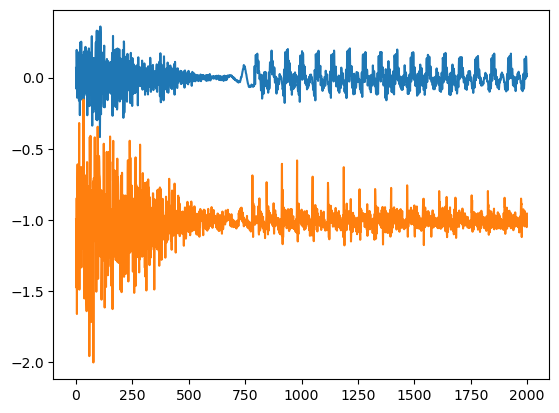

In [78]:
from librosa import util, lpc
from scipy.signal import windows, fftconvolve
from tensorflow.signal import overlap_and_add

def lpcresidual(y, fs, target_fs=16000, frame_length_sec=0.04, step_sec=0.005):    
    """Compute the residual signal after LPC inverse filtering.

**Note** that the length of this array is usually smaller than the length of the 
input array.  The length will be based on the number of frames and the the step size.  
`L = (num_frames-1) * step + frame_length`, where `step = step_sec*target_fs`, and 
`frame_length = frame_length_sec*target_fs`.

The LPC order is equal to (target_fs/1000) + 2, which is by default is 18.

Parameters
==========
    y : ndarray
        A one-dimensional array of audio samples
    fs : int
        Sampling rate of **x**
    target_fs: int, default = 16000
        Algorithms from the covarep library of voice analysis require target_fs=16000
    frame_length_sec: float, default = 0.04
        The duration of the LPC analysis window, 40 milliseconds
    step_sec: float, default = 0.005
        The interval between successive frames in the LPC analysis, 5 milliseconds

Returns
=======
    lpc_residual : ndarray
        A one-dimensional array -- the residual derived by inverse filtering the input 
        audio signal. 
    fs : int

    
    """
    lpc_order = int(target_fs/1000) + 2
    
    x, fs = phon.prep_audio(y, fs, target_fs=target_fs, pre = 0, quiet=True)  # resample
    
    frame_length = int(fs * frame_length_sec) # number of samples in a frame
    step = int(fs * step_sec)  # number of samples between frames, hop

    frames = util.frame(x, frame_length=frame_length, hop_length=step,axis=0)   # view as frames
    frames = np.multiply(frames,windows.hamming(frame_length))   # apply a Hamming window to each frame

    A = lpc(frames, order=lpc_order)  # get lpc coefficients
    inv = fftconvolve(frames,A,mode="same",axes=1) # inverse filter, 
    inv = inv * np.sum(np.square(frames))/np.sum(np.square(inv))
    
    lpc_resid = overlap_and_add(inv,step)  # put frames back together into waveform with overlap and add
    lpc_resid = lpc_resid/np.max(np.fabs(lpc_resid))

    return lpc_resid,fs


example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
x,fs = phon.prep_audio(x, fs, target_fs=16000, pre = 0, quiet=True)  # resample, preemphasis
resid,fs = lpcresidual(x,fs)

start = 10000
end = start + 2000
plt.plot(x[start:end])
plt.plot(-1 + resid[start:end])
print(x.shape,resid.shape)

In [86]:
from librosa import feature, util, lpc
from scipy.signal import windows, find_peaks, spectrogram, peak_prominences, fftconvolve
from scipy import fft
from scipy import linalg
from pandas import DataFrame
from tensorflow.signal import overlap_and_add

def get_f0_srh(y, fs, f0_range = [60,400]):
    """Track the fundamental frequency of voicing (f0), using a frequency domain method.

This function is an implementation of Drugman and Alwan's (2011) "Summation of 
Residual Harmonics" (SRH) method of pitch tracking.  The signal is downsampled to 
10 kHz, and inverse filtered with LPC analysis to remove the influence of vowel 
formants. Then harmonics are found in the spectrum of the residual signal.
Drugman and Alwan found that this technique provides an estimate of F0 that is 
robust when the audio signal is corrupted by noise. 

Probability of voicing is given from a logistic regression formula using `rms` and `srh` trained to predict the voicing state as determined by EGG data using the function `phonlab.egg_to_oq()` over the 10 speakers in the ASC corpus of Mandarin speech. The prediction of the EGG voicing decision was about 75% correct.

Parameters
==========
    y : string or ndarray
        A one-dimensional array of audio samples
    fs : int
        Sampling rate of **x**
    f0_range : list of two integers, default = [63,400]
        The lowest and highest values to consider in pitch tracking. This algorithm is quite sensitive to the values given in this setting.

Returns
=======
    df : pandas DataFrame  
        measurements at 5 msec intervals.

Note
====
The columns in the returned dataframe are for each frame of audio:
    * sec - time at the midpoint of each frame
    * f0 - estimate of the fundamental frequency
    * rms - peak normalized rms amplitude in the band from 0 to 5 kHz
    * srh - value of SRH (normalized sum of the residual harmonics)
    * probv - estimated probability of voicing
    * voiced - a boolean, true if probv>0.5

References
==========

T. Drugman, A. Alwan (2011) Joint robust voicing detection and pitch estimation based on residual harmonics. 'ISCA (Florence, Italy)' pp. 1973ff

    
    """
    frame_length_sec = 0.04  # 40 ms frame
    step_sec = 0.005

    x,fs = phon.prep_audio(y, fs, target_fs=16000, pre = 0.96, quiet=True)  # resample, preemphasis
    
    frame_length = int(fs * frame_length_sec) 
    half_frame = frame_length//2
    step = int(fs * step_sec)  # number of samples between frames

    rms = feature.rms(y=x,frame_length=frame_length, hop_length=step,center=False)
    rms = 20*np.log10(rms[0]/np.max(rms[0]))

    resid,fs = lpcresidual(x,fs)

    w = windows.hamming(frame_length)
    frames = util.frame(resid, frame_length=frame_length, hop_length=step,axis=0)    
    frames = np.multiply(frames,w)   # apply a Hamming window to each frame, for lpc

    nb = frames.shape[0]  # the number of frames (or blocks) in the LPC analysis
    sec = (np.array(range(nb)) * step + half_frame).astype(int)/fs

    Sxx = np.abs(np.fft.rfft(frames,2**14))           # spectrum of inverse

    Sxx = np.divide(Sxx.T,linalg.norm(Sxx,axis=-1))
    
    print(f'Sxx.shape = {Sxx.shape}')
                     
    f0 = np.empty(nb)
    SRHval = np.empty((nb))

    while (True):
        for i in range(nb): 
            S = Sxx[:,i]
            T = len(S)/fs
            srh_max = 0
            max_harmonic = 6
            for f in range(f0_range[0], f0_range[1]): 
                fT = f*T  # test this as frequency of H1
                plus = 0
                minus = 0
                for k in range(1,max_harmonic):
                    plus += S[int(fT*k)] 
                    minus += S[int(fT*(k+0.5))]
                srh = plus-minus  #/(max_harmonic-1)
                if srh > srh_max:
                    srh_max = srh
                    f0[i] = f        
            SRHval[i] = srh_max
        if np.max(SRHval) > 0.1:  # if there were some bad fitting estimates
            F0median = np.nanmedian(np.where(SRHval>0.1,f0,np.nan))
            print(f'median f0 = {F0median}')
            if F0median*0.5 > f0_range[0]:
                f0_range[0] = int(F0median*0.5)
            elif F0median*2 < f0_range[1]:
                f0_range[1] = int(F0median*2)
            else:
                break  # no further pitch range adjustment is allowed

    odds = np.exp(2.75 + (0.12*rms) + (0.4*SRHval))  # logistic formula, trained on ASC corpus
    probv = odds / (1 + odds)
    voiced = probv > 0.5

    return DataFrame({'sec': sec, 'f0':f0, 'rms':rms, 'srh':SRHval, 'probv': probv, 'voiced':voiced})

example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
f0_srh = get_f0_srh(x,fs,f0_range=[50,400])
#f0_srh.loc[f0_srh["voiced"] == False, ("f0")] = np.nan # ignore nonvocalic formants


ret = phon.sgram(x,fs,cmap="Grays") # draw a spectrogram of the sound
ax2 = ret[0].twinx()  # and twin it for plotting f0
ax2.plot(f0_srh.sec,f0_srh.srh, 'ro')


Sxx.shape = (8193, 488)
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
median f0 = 370.5
medi

KeyboardInterrupt: 

## Test the get_f0_B93 routine

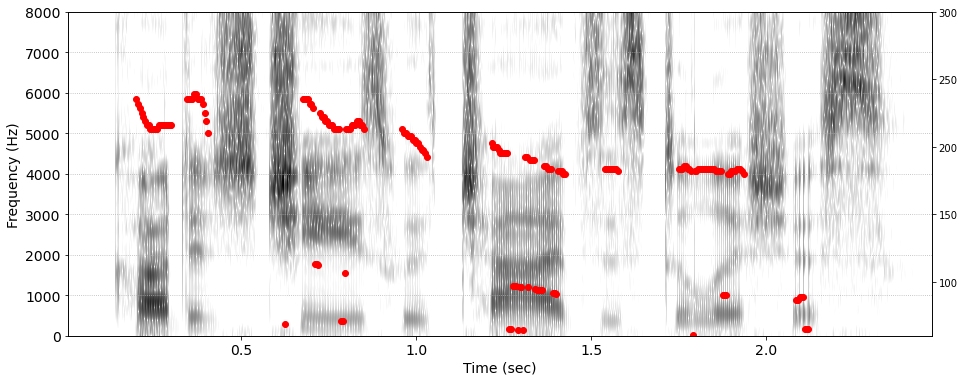

In [47]:

example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file, chansel=[0])

f0_range=[60,300]
f0_B93 = phon.get_f0_B93(x, fs, f0_range = f0_range)
f0_B93.loc[f0_B93["voiced"] == False, ("f0","HNR")] = np.nan # ignore nonvocalic formants

ret = phon.sgram(x,fs,cmap="Grays") # draw a spectrogram of the sound
ax2 = ret[0].twinx()  # and twin it for plotting f0
ax2.plot(f0_B93.sec,f0_B93.f0, 'ro')
ax2.set_ylim(f0_range)

Audio(x,rate=fs)

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/fricatives.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
if fs>32000: target_fs=32000
else: target_fs = fs
y,fs = phon.prep_audio(x,fs, target_fs = target_fs, outtype = 'int')

frics_list = {"/f/": 0.322, "/θ/": 1.235, "/s/": 2.158, "/ʃ/": 3.214, "/x/": 4.189, "/h/": 5.06}

fig,axes = plt.subplots(nrows=3,ncols=2,sharex="all",sharey="all")
print(axes.shape)

row = col = 0
for key,value in frics_list.items():
    Fm,Am,AmpD,Fsec,Asec,mode,COG,SD,Skew,Kurtosis,spec,freq = phon.fricative(y,fs,value)

    ax = axes[row][col]
    ax.plot(freq,spec)
    ax.axvline(Fm,color="red")
    ax.text(15000,62,key)
    ax.text(7250,31,f"COG={COG:.0f}")
    ax.text(7250,24,f"Fm={Fm:.0f}")
    ax.text(7250,17,f"AmpD={AmpD:.0f}")
    if not np.isnan(Fsec): 
        ax.axvline(Fsec,color="red")
    ax.axvline(COG,color="green")
    col = col + 1
    if col>1:
        col=0
        row = row + 1


In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

aud = phon.Audspec()
aud.make_zgram(x,fs)

# ---- the rest is to make a nice plot ----

fig,ax = plt.subplots(2,figsize=(8,6))

Hz_extent = (min(aud.time_axis), max(aud.time_axis),
      min(aud.fft_freqs), max(aud.fft_freqs))  # time and frequency values for sgram.
ax[0].imshow(20*np.log10(aud.sgram.T),origin='lower', aspect='auto',
         extent=Hz_extent, cmap = plt.cm.Greys)
ax[0].set(xlabel="Time (sec)", ylabel="Frequency (Hz)")
ax[1].imshow(aud.zgram.T,origin='lower', aspect='auto', interpolation="spline36",
         extent=aud.extent, cmap = plt.cm.Purples)
ax[1].set(xlabel="Time (sec)", ylabel="Frequency (Bark)")
fig.tight_layout()

In [ ]:
aud.make_sharpgram()

fig,ax = plt.subplots(1,figsize=(8,3))

ax.imshow(aud.sharpgram.T,origin='lower', aspect='auto',
         extent=aud.extent, interpolation="spline36", cmap = plt.cm.Reds)
ax.set(xlabel="Time (sec)", ylabel="Frequency (Bark)")


In [ ]:
aud.make_tgram()

fig,ax = plt.subplots(1,figsize=(8,3))

ax.imshow(aud.tgram.T,origin='lower', aspect='auto',
         extent=aud.extent, interpolation="spline36", cmap = plt.cm.afmhot)
ax.set(xlabel="Time (sec)", ylabel="Frequency (Bark)")

# testing f0_tracking

In [ ]:

example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'im_twelve.wav'
x,fs = phon.loadsig(example_file, chansel=[0])

f0_range=[60,400]

df = phon.get_f0_B93(x,fs,f0_range=f0_range)
df.loc[df["voiced"] == False, ("f0","HNR")] = np.nan # ignore devoiced frames

df2 = phon.get_f0_acd(x,fs)
df2.loc[df2["voiced"] == False, ("f0","H1H2")] = np.nan # ignore devoiced frames


ret = phon.sgram(x,fs,cmap="Blues") # draw a spectrogram of the sound
ax2 = ret[0].twinx()  # and twin it for plotting f0

ax2.plot(df.sec,df.f0, 'ro',label="B93")
ax2.plot(df2.sec,df2.f0, 'k.',label="acd")  
ax2.legend()
ax2.set_ylim(f0_range)

## Rhythm functions

In [ ]:
x,fs = phon.loadsig("s09003.wav")
slice = x[fs*3:fs*7]

f,Sx = phon.get_rhythm_spectrum(slice,fs)
plt.plot(f,Sx)
plt.xlabel("frequency (Hz)")
Audio(slice,rate=fs)

In [ ]:
x,fs = phon.loadsig("s1202a.wav", chansel=[0])
f,ts,Sxx = phon.rhythmogram(x,fs)  # calculate rhythm spectra over time
         
m = np.mean(Sxx,axis=0)  # the mean spectrum of the file
sd = np.std(Sxx,axis=0)  # the standard deviation of the spectrum
Sxx_thresh = Sxx - (m + 0.5*sd)   # subtract a threshold to find "rhythmic" sections
        
start = 136
end = 166
s = np.int32((start-2) *2)  # start frame, two frames per second
e = np.int32((end-2) *2) # end frame
extent = (start,end,min(f),max(f))  # get the time and frequency values for figure.
         
plt.imshow(Sxx_thresh.T[:,s:e], aspect='auto', extent = extent, 
               origin='lower',cmap="coolwarm",interpolation="spline36")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")

## loadsig() and prep_audio()

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

# --------
ret = phon.loadsig(example_file)  # taking just the left channel
fs_orig = ret.pop()
x = ret[0]

# or you can say 

*chans, fs_orig = phon.loadsig(example_file)
x = chans[0]

# or you can say 

x, fs_orig = phon.loadsig(example_file, chansel=[0])

# --------

y,fs = phon.prep_audio(x,fs_orig,outtype='int')
print(np.max(y))

y,fs = phon.prep_audio(x,fs_orig,outtype='float')
print(np.max(y))

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

x,fs = phon.loadsig(example_file, chansel=[0])
f0_range = [60,400]

f0df = phon.get_f0_B93(x,fs)
f0df.loc[f0df["voiced"] == False, ("f0")] = np.nan # ignore voiceless frames

f0df1 = phon.get_f0_acd(x,fs,prom=18)
f0df1.loc[f0df1["voiced"]==False, ("f0")] = np.nan # ignore voiceless frames

snd = parselmouth.Sound(str(example_file)).extract_left_channel()  # create a Praat Sound object
pitch = snd.to_pitch()  # create a Praat pitch object
f0df2 = phon.pitch_to_df(pitch)  # convert it into a Pandas dataframe

ret = phon.sgram(x,fs,cmap='Grays') # draw a spectrogram of the sound

ax1 = ret[0]  # get the plot axis
ax2 = ax1.twinx()  # and twin it for plotting f0
ax2.plot(f0df2.sec,f0df2.f0-10, color='chartreuse',marker="s",
         linestyle = "none",label="praat")
ax2.plot(f0df.sec,f0df.f0, color='dodgerblue',marker="d",
         linestyle = "none",label="B93")  
ax2.plot(f0df1.sec,f0df1.f0+10, color='orange',marker="d",
         linestyle='none',label="acd")

ax2.legend(fontsize="x-large")
ax2.set_ylim(f0_range)
ax2.set_ylabel("F0 (Hz)", size=14)
for item in ax2.get_yticklabels(): item.set_fontsize(14)

In [ ]:
# 1-D example
x = np.linspace(0,100,2**6);
y = np.cos(x/10)+(x/50)**2 + np.random.random_sample(len(x))/2;
y[[14, 17, 20]] = [2, 2.5, 3];

z,s,e = phon.smoothn(y); # Regular smoothing
zr,sr,e = phon.smoothn(y,isrobust=True); # Robust smoothing

print(f'regular smoothing factor = {s:.3f}, robust smoothing factor = {sr:.3f}')

plt.subplot(121), 
plt.plot(x,y,'r.')
plt.plot(x,z,'k')
plt.title("Smoothed")

plt.subplot(122)
plt.plot(x,y,'r.')
plt.plot(x,zr,'k')
plt.title("Robust Smoothing")


## phon.track_formants()

Python native code implements both LPC and Inverse Filter Control (IFC) vowel formant tracking. 

IFC doesn't care if the waveform format is float or int

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'
x,fs = phon.loadsig(example_file, chansel=[0])
fmtsdf = phon.track_formants(x, fs, method='lpc',speaker=2,f0_range=[60,350])

ret = phon.sgram(x,fs, tf=6000, cmap="Reds")  # plot the spectrogram

dot_color = "dodgerblue"
sns.pointplot(fmtsdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

fmtsdf.head()
fmtsdf.to_csv("sf3_cln.csv",index=False)

In [ ]:
VTL = phon.get_deltaF(fmtsdf, return_value="VTL")
deltaF = phon.get_deltaF(fmtsdf)
print(f'deltaF = {deltaF:.0f}, vocal tract length is {VTL:.2f}')


phon.deltaF_norm(fmtsdf,deltaF = deltaF)
fmtsdf.head()

## phon.sgram()

Makes a pretty good looking spectrogram

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

x,fs = phon.loadsig(example_file, chansel=[0])
x,fs = phon.prep_audio(x,fs,target_fs=24000)

phon.sgram(x,fs)

#Audio(example_file)
Audio(x,rate=fs)

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'
x,fs = phon.loadsig(example_file,chansel=[0])

ret = phon.sgram(x,fs,start=1.5, end=2.0,slice_time=1.615)
ax1 = ret[0]
ax1.axvline(1.71,color="red")

### phon.formant2df

One of the **Tidypraat** routines working with parselmouth to call Praat functions in python

In [ ]:
snd = parselmouth.Sound(str(example_file))  # create a Praat Sound object
maxf = 5500       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
fmntdf = phon.formant_to_df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

sns.pointplot(fmntdf,x='sec',y='F1',linestyle='none',native_scale=True)
sns.pointplot(fmntdf,x='sec',y='F2',linestyle='none',native_scale=True)
sns.pointplot(fmntdf,x='sec',y='F3',linestyle='none',native_scale=True)

fmntdf.head()

## phon.amplitude_envelope()

Here's an intersting application of one of the phonab functions.  Get the amplitude envelope in a low frequency band, and then in a high frequency band.  The difference between them (plotted in red over the spectrogram below) segments the speech into consonant and vowel regions.  Above zero is 'vocalic' and below zero is 'consonantal'.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

x,fs = phon.loadsig(example_file, chansel=[0])

lband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[120,3000],target_fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[3000,5999],target_fs=12000)

diff = lband-hband  # the difference in the low and high envelopes
time_axis = np.arange(len(diff))/fs_diff  # a time axis for envelope plotting

ax1,f,t,Sxx = phon.sgram(x,fs,cmap='Blues') # draw the spectrogram from the array of samples

ax2 = ax1.twinx()
ax2.plot(time_axis,diff, color = "red")  # add scaled diff function
ax2.axhline(0) 

Audio(example_file)

### Vocalic

This code block uses the diff[] array plotted above to define a **vocalic** feature, 
and then uses that feature to clean up the formant plot.  This is really only needed for 
nice looking graphs.  Illustrating here the three main formant tracking algorithms.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

# 1) IFC formant tracking
x,fs = phon.loadsig(example_file, chansel=[0])

# 2) Python native LPC formant tracking
fmtsdf = phon.track_formants(x,fs,method='ifc',order = 10, speaker=2)

# 3) Praat LPC formant tracking
snd = parselmouth.Sound(str(example_file))  # create a Praat Sound object
maxf = 6000       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
fmtdf = phon.formant_to_df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

# ------ use "vocalic" to decide which formant measurements to draw --------  # note pre=0 is important here
lband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[120,3000],target_fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[3000,5999],target_fs=12000)
diff = lband-hband  # the difference in the low and high envelopes
fmtsdf["vocalic"] = diff[(fmtsdf['sec']*fs_diff).astype(int)]>0.005  # add 'vocalic' to the dataframe
fmtsdf.loc[fmtsdf["vocalic"] == False, ("F1","F2","F3","F4")] = np.nan # ignore nonvocalic formants

phon.sgram(x,fs, cmap="Blues")  # plot the spectrogram

# add formant dots to the spectrogram
dot_color = "red"
sns.pointplot(fmtsdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

dot_color = "lightgreen"
sns.pointplot(fmtdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

## phon.fricative()

Implements both major peak analysis and moments analysis.  The spectrum at time 0.635 (the 'ch' in 'cheese') illustrates that the "major peak" is the first well separated peak, not the point of maximum amplitude in the spectrum.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

x,fs = phon.loadsig(example_file, chansel=[0])
print(fs)
x,fs = phon.prep_audio(x,fs, target_fs=22050,outtype = 'int')
print(fs)

Fm,Am,AmpD,Fsec,Asec,mode,COG,SD,Skew,Kurtosis,spec,freq = phon.fricative(x,fs,0.27)

print(f"first major peak at {Fm:.1f}, Center of Gravity is {COG:.1f}")
plt.plot(freq,spec)
plt.axvline(Fm,color="red")
plt.axvline(COG,color="green")

## phon.burst()

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'im_twelve.wav'

x,fs = phon.loadsig(example_file, chansel=[0])  
x,fs = phon.prep_audio(x,fs, target_fs=16000, pre=0.94) # add preemphasis, resample to 22050, ensure correct polarity, and scale to use maximum range

t1 = 0.1
t2 = 0.5

b_time, b_score = phon.burst(x,fs, t1,t2)  # find a stop burst in the span from t1 to t2
print(f"the stop release burst is at time: {b_time:.3f} seconds")
 
ax1,f,t,Sxx = phon.sgram(x,fs,start=t1, end=t2)
ax1.axvline(b_time,color="red")


## phon.egg_to_oq()

With a stereo audio file having audio in the left (channel 0) and electroglottography in the right (channel 1),
this function returns a time axis, f0, and open quotient.


In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/F1_bha24_1.wav'

egg,audio,fs = phon.loadsig(example_file, chansel=[1,0])  
oqdf = phon.egg_to_oq(egg,fs)  # return open quotient data

f01df = phon.get_f0acd(audio,fs)

# ------ The rest of this example is making a nice plot ---------

time = [i/fs for i in range(audio.size)]  # the times of the audio samples.

start_time = 0.1
end_time = start_time + 0.6

sf = np.abs(oqdf.sec - start_time).argmin()  # closest frame to start_time
ef = np.abs(oqdf.sec - end_time).argmin()      # closest frame to end_time

si = int(oqdf.sec.iloc[sf]*fs)  # index of those frame times
ei = int(oqdf.sec.iloc[ef]*fs)    # in the audio and egg signals

fig = plt.figure()
ax1 =fig.add_subplot(411)
ax1.plot(time[si:ei],audio[si:ei],label="audio")
ax1.set_xlim(start_time,end_time)
ax1.set_xticklabels(([]))
ax1.legend()

ax2 =fig.add_subplot(412,sharex=ax1)
ax2.plot(time[si:ei],egg[si:ei],label="EGG")
ax2.legend()

ax3 =fig.add_subplot(413,sharex=ax1)
ax3.plot(oqdf.sec.iloc[sf:ef],oqdf.OQ.iloc[sf:ef],label="OQ")
ax3.legend()

ax4 =fig.add_subplot(414)
ax4.plot(oqdf.sec.iloc[sf:ef],oqdf.f0.iloc[sf:ef],label="F0")
ax4.set_xlim(start_time,end_time)
ax4.legend()

Audio(audio,rate=fs)

## phon.sine_synth()

With a formants data frame from phon.track_formants(), sine_synth() produces sine wave analogs of speech.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'

x,fs = phon.loadsig(example_file)   # illustrating here that we can pass an array to track_formants()
fmtsdf = phon.track_formants(x,fs)    # track the formants

x2,fs2 = phon.sine_synth(fmtsdf)     # use the formants to produce sinewave synthesis
phon.sgram(x2,fs2, band="nb", preemph=0)  # plot a spectrogram of it

Audio(x2,rate=fs2) 

## phon.sigcor_noise()

Replace signal with noise that matches the amplitude envelope of the signal

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'

x,fs = phon.loadsig(example_file)   # illustrating here that we can pass an array to track_formants()
y,fs = phon.sigcor_noise(x,fs,flip_rate=0.4,start=1.2,end=1.5)

time_axis = np.arange(len(y))/fs
plt.plot(time_axis,y)  # add_noise pads the signal by 0.5 seconds

phon.sgram(y,fs,preemph=0)
Audio(y,rate=fs) 

## phon.add_noise()

A function that can be used to prepare speech in noise (SPIN) stimuli.


In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/im_twelve.wav'

x,fs = phon.loadsig(example_file)   # illustrating here that we can pass an array to track_formants()
y,fs = phon.add_noise(x,fs,"babble",snr=3)
time_axis = np.arange(len(y))/fs

plt.plot(time_axis - 0.5,y)  # add_noise pads the signal by 0.5 seconds
y,fs = phon.prep_audio(y,fs,target_fs=None,pre=0)
phon.sgram(y,fs)
Audio(y,rate=fs) 

## phon.vocode()

Resynthesize speech with noise in frequency bands, simulating the amount of audio information in a cochlear implant.

In [ ]:
example_file = importlib.resources.files('phonlab') / 'data/example_audio/sf3_cln.wav'

bands_third = phon.third_octave_bands(high=8000)  # define filter bank
bands_shan = phon.shannon_bands(high=8000,nc=10)  # define filter bank

x,fs = phon.loadsig(example_file,chansel=[0])   
y,fs = phon.vocode(x, fs, bands_shan)  # use one of the filter banks

time_axis = np.arange(len(y))/fs
plt.plot(time_axis,y)

phon.sgram(y,fs)

Audio(y,rate=fs) 